# Vehicle Number Plate Detection with YOLOv8

This notebook will:

1) Inspect and visualize the dataset (images + Pascal VOC XML labels) — verify outputs.
2) Convert XML annotations to YOLO format and split into train/val/test — verify outputs.
3) Prepare a data.yaml for Ultralytics YOLOv8 — verify outputs.
4) Train a YOLOv8 model once dependencies are available.

Run cells in order and confirm each verification output before proceeding.

Found 433 images and 433 xml annotations
Class distribution (first few xmls): Counter({'licence': 5})
Image shapes (first few xmls): Counter({(500, 268): 1, (400, 248): 1, (400, 225): 1, (400, 267): 1, (400, 300): 1})
Sample filenames: [('Cars0.png', 500, 268), ('Cars1.png', 400, 248), ('Cars10.png', 400, 225), ('Cars100.png', 400, 267), ('Cars101.png', 400, 300)]


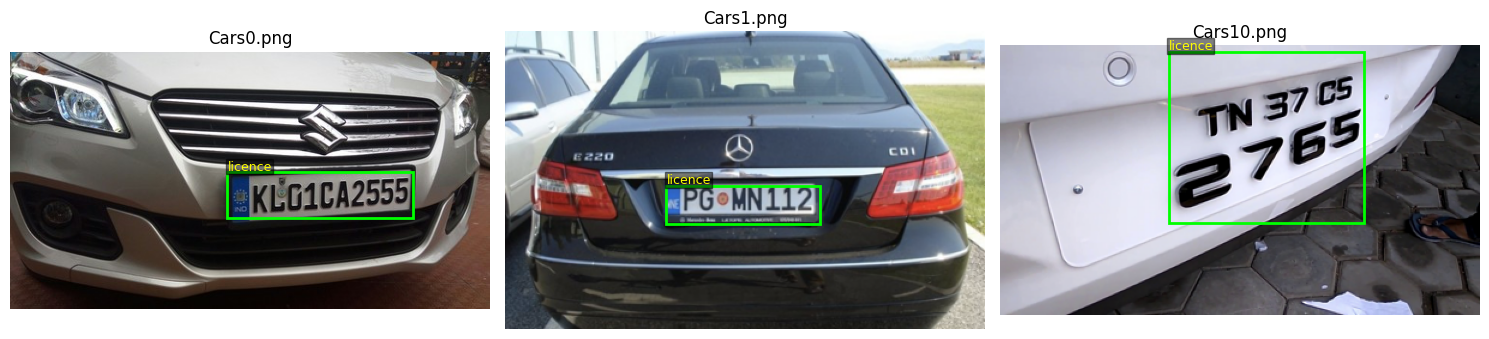

VERIFIED: Dataset is readable, XMLs parsed, and sample visualizations displayed.


In [2]:
from pathlib import Path
import xml.etree.ElementTree as ET
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt

IMG_DIR = Path('data/images')
ANN_DIR = Path('data/annotations')

xml_files = sorted(ANN_DIR.glob('*.xml'))
img_files = sorted(IMG_DIR.glob('*.png'))
print(f"Found {len(img_files)} images and {len(xml_files)} xml annotations")

# Parse a few xmls and collect classes
classes = Counter()
shapes = Counter()

samples = []
for xf in xml_files[:5]:
    tree = ET.parse(xf)
    root = tree.getroot()
    filename = root.findtext('filename')
    w = int(root.find('size/width').text)
    h = int(root.find('size/height').text)
    shapes[(w, h)] += 1
    for obj in root.findall('object'):
        name = obj.findtext('name')
        classes[name] += 1
    samples.append((filename, w, h))

print('Class distribution (first few xmls):', classes)
print('Image shapes (first few xmls):', shapes)
print('Sample filenames:', samples)

# Visualize 3 sample images with their bbox from XML
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, xf in zip(axes, xml_files[:3]):
    root = ET.parse(xf).getroot()
    fname = root.findtext('filename')
    img_path = IMG_DIR / fname
    im = Image.open(img_path).convert('RGB')
    ax.imshow(im)
    for obj in root.findall('object'):
        bb = obj.find('bndbox')
        xmin, ymin = int(bb.findtext('xmin')), int(bb.findtext('ymin'))
        xmax, ymax = int(bb.findtext('xmax')), int(bb.findtext('ymax'))
        # draw rectangle
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                   fill=False, edgecolor='lime', linewidth=2))
        ax.text(xmin, ymin-2, obj.findtext('name'), color='yellow', fontsize=9,
                bbox=dict(facecolor='black', alpha=0.5, pad=1))
    ax.set_title(fname)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Verification checkpoint
print('VERIFIED: Dataset is readable, XMLs parsed, and sample visualizations displayed.')

In [3]:
import random, shutil, yaml

random.seed(42)

# Define class list from inspection; normalize to single class 'licence'
CLASSES = ['licence']

BASE = Path('.')
YOLO_DIR = BASE / 'yolo_dataset'
for sub in ['images/train', 'images/val', 'images/test', 'labels/train', 'labels/val', 'labels/test']:
    (YOLO_DIR / sub).mkdir(parents=True, exist_ok=True)

# Helper: voc->yolo

def voc_box_to_yolo(box, img_w, img_h):
    xmin, ymin, xmax, ymax = box
    x_c = (xmin + xmax) / 2.0 / img_w
    y_c = (ymin + ymax) / 2.0 / img_h
    w = (xmax - xmin) / img_w
    h = (ymax - ymin) / img_h
    return x_c, y_c, w, h

# Gather all items
items = []
for xf in xml_files:
    root = ET.parse(xf).getroot()
    fname = root.findtext('filename')
    img_path = IMG_DIR / fname
    if not img_path.exists():
        continue
    img_w = int(root.find('size/width').text)
    img_h = int(root.find('size/height').text)
    yolo_lines = []
    for obj in root.findall('object'):
        name = obj.findtext('name').strip().lower()
        if name not in CLASSES:
            # map any variant to 'licence'
            name = 'licence'
        cls_id = CLASSES.index(name)
        bb = obj.find('bndbox')
        xmin, ymin = int(bb.findtext('xmin')), int(bb.findtext('ymin'))
        xmax, ymax = int(bb.findtext('xmax')), int(bb.findtext('ymax'))
        x_c, y_c, w, h = voc_box_to_yolo((xmin, ymin, xmax, ymax), img_w, img_h)
        yolo_lines.append(f"{cls_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")
    items.append((img_path, '\n'.join(yolo_lines)))

print(f'Total valid items: {len(items)}')

# Split
random.shuffle(items)
N = len(items)
train_n = int(0.8 * N)
val_n = int(0.1 * N)

splits = {
    'train': items[:train_n],
    'val': items[train_n:train_n+val_n],
    'test': items[train_n+val_n:],
}

for split, split_items in splits.items():
    for img_path, lbl_txt in split_items:
        dest_img = YOLO_DIR / f'images/{split}/{img_path.name}'
        dest_lbl = YOLO_DIR / f'labels/{split}/{img_path.stem}.txt'
        shutil.copy2(img_path, dest_img)
        dest_lbl.write_text(lbl_txt)

# Write data.yaml
DATA_YAML = YOLO_DIR / 'data.yaml'
data = {
    'path': str(YOLO_DIR.resolve()),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {0: 'licence'},
}
DATA_YAML.write_text(yaml.safe_dump(data, sort_keys=False))

# Verification
print('VERIFIED: YOLO dataset prepared at:', YOLO_DIR.resolve())
print('Counts:', {k: len(v) for k, v in splits.items()})
print('Sample label file:', next((YOLO_DIR/ 'labels/train').glob('*.txt')).read_text()[:200])

Total valid items: 433
VERIFIED: YOLO dataset prepared at: /home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolo_dataset
Counts: {'train': 346, 'val': 43, 'test': 44}
Sample label file: 0 0.249167 0.750000 0.241667 0.144444
VERIFIED: YOLO dataset prepared at: /home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolo_dataset
Counts: {'train': 346, 'val': 43, 'test': 44}
Sample label file: 0 0.249167 0.750000 0.241667 0.144444


In [4]:
import importlib, subprocess, sys

def ensure_pkg(pkg):
    try:
        return importlib.import_module(pkg)
    except ImportError:
        print(f"Package {pkg} not found. Attempting to install...")
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])
        except Exception as e:
            print(f"Install failed for {pkg}: {e}\nIf you are offline, please connect to the internet or provide a local wheel for installation.")
        return importlib.import_module(pkg)

# Verify ultralytics is importable
try:
    import ultralytics
    from ultralytics import YOLO
    print('VERIFIED: ultralytics imported successfully.')
except Exception as e:
    print(' ultralytics not available yet:', e)
    # Do not proceed to training until this succeeds

VERIFIED: ultralytics imported successfully.


In [4]:
# Train YOLOv8 only if ultralytics is present
try:
    from ultralytics import YOLO
    data_yaml = str((Path('yolo_dataset') / 'data.yaml').resolve())
    model = YOLO('yolov8n.pt')  # nano model for speed
    results = model.train(data=data_yaml, epochs=5, imgsz=640, batch=16, project='runs_yolo', name='plate_det_v8n', exist_ok=True)
    print('VERIFIED: Training started/completed. See runs folder for logs.')
except Exception as e:
    print('Training skipped/unavailable:', e)

# If training ran, try validation and visualization
try:
    metrics = model.val()
    print('VERIFIED: Validation metrics:', metrics.results_dict)
    # Inference on a few test images
    sample_imgs = list((Path('yolo_dataset')/ 'images/test').glob('*.png'))[:3]
    if sample_imgs:
        preds = model.predict(sample_imgs, save=True, project='runs_yolo', name='pred_samples', exist_ok=True)
        print('VERIFIED: Prediction images saved.')
    else:
        print('No test images found to run prediction preview.')
except Exception as e:
    print('Post-training checks skipped/unavailable:', e)

Ultralytics 8.3.176 🚀 Python-3.10.18 torch-2.8.0+cpu CPU (Intel Core(TM) i5-8350U 1.70GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=plate_det_v8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 


  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 

train: Scanning /home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolo_dataset/labels/train... 346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:01<00:00, 212.14it/s]

train: New cache created: /home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolo_dataset/labels/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 295.3±106.2 MB/s, size: 463.6 KB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 295.3±106.2 MB/s, size: 463.6 KB)



/home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolovenv/lib64/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolo_dataset/labels/val... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 233.99it/s]

val: New cache created: /home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolo_dataset/labels/val.cache



/home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolovenv/lib64/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs_yolo/plate_det_v8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs_yolo/plate_det_v8n
Starting training for 5 epochs...
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs_yolo/plate_det_v8n
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size

      Epoch    GPU_mem   box_loss   

        1/5         0G      1.432      2.974      1.293         20        640: 100%|██████████| 22/22 [16:54<00:00, 46.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:34<00:00, 17.42s/it]

                   all         43         49    0.00372       0.98      0.242      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.428      1.983      1.242         20        640: 100%|██████████| 22/22 [16:12<00:00, 44.22s/it]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:29<00:00, 14.59s/it]

                   all         43         49    0.00364      0.959      0.333      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.404      1.716      1.228         20        640: 100%|██████████| 22/22 [23:23<00:00, 63.78s/it] 
        3/5         0G      1.404      1.716      1.228         20        640: 100%|██████████| 22/22 [23:23<00:00, 63.78s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:29<00:00, 14.86s/it]

                   all         43         49      0.926      0.256      0.559      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.397      1.648      1.217         20        640: 100%|██████████| 22/22 [14:27<00:00, 39.43s/it]
        4/5         0G      1.397      1.648      1.217         20        640: 100%|██████████| 22/22 [14:27<00:00, 39.43s/it]]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.84s/it]

                   all         43         49      0.573      0.388      0.368      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.328      1.506      1.161         22        640: 100%|██████████| 22/22 [19:45<00:00, 53.87s/it] 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.03s/it]

                   all         43         49      0.641      0.729      0.649      0.325



5 epochs completed in 1.557 hours.
Optimizer stripped from runs_yolo/plate_det_v8n/weights/last.pt, 6.2MB
Optimizer stripped from runs_yolo/plate_det_v8n/weights/last.pt, 6.2MB
Optimizer stripped from runs_yolo/plate_det_v8n/weights/best.pt, 6.2MB
Optimizer stripped from runs_yolo/plate_det_v8n/weights/best.pt, 6.2MB

Validating runs_yolo/plate_det_v8n/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.10.18 torch-2.8.0+cpu CPU (Intel Core(TM) i5-8350U 1.70GHz)

Validating runs_yolo/plate_det_v8n/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.10.18 torch-2.8.0+cpu CPU (Intel Core(TM) i5-8350U 1.70GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.08s/it]



                   all         43         49      0.619      0.714      0.646      0.323
Speed: 9.1ms preprocess, 251.9ms inference, 0.0ms loss, 25.8ms postprocess per image
Results saved to runs_yolo/plate_det_v8n
Speed: 9.1ms preprocess, 251.9ms inference, 0.0ms loss, 25.8ms postprocess per image
Results saved to runs_yolo/plate_det_v8n
VERIFIED: Training started/completed. See runs folder for logs.
Ultralytics 8.3.176 🚀 Python-3.10.18 torch-2.8.0+cpu CPU (Intel Core(TM) i5-8350U 1.70GHz)
VERIFIED: Training started/completed. See runs folder for logs.
Ultralytics 8.3.176 🚀 Python-3.10.18 torch-2.8.0+cpu CPU (Intel Core(TM) i5-8350U 1.70GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.9±4.3 ms, read: 35.8±21.6 MB/s, size: 509.4 KB)
val: Fast image access ✅ (ping: 1.9±4.3 ms, read: 35.8±21.6 MB/s, size: 509.4 KB)


val: Scanning /home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolo_dataset/labels/val.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
/home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolovenv/lib64/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolo_dataset/labels/val.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
/home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolovenv/lib64/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Insta

                   all         43         49      0.662      0.719      0.658      0.337
Speed: 4.7ms preprocess, 298.7ms inference, 0.0ms loss, 32.9ms postprocess per image
Results saved to runs_yolo/plate_det_v8n
Speed: 4.7ms preprocess, 298.7ms inference, 0.0ms loss, 32.9ms postprocess per image
Results saved to runs_yolo/plate_det_v8n
VERIFIED: Validation metrics: {'metrics/precision(B)': np.float64(0.6617987452672164), 'metrics/recall(B)': np.float64(0.7188979693364776), 'metrics/mAP50(B)': np.float64(0.6580823569003135), 'metrics/mAP50-95(B)': np.float64(0.33663396043963617), 'fitness': np.float64(0.3687788000857039)}

VERIFIED: Validation metrics: {'metrics/precision(B)': np.float64(0.6617987452672164), 'metrics/recall(B)': np.float64(0.7188979693364776), 'metrics/mAP50(B)': np.float64(0.6580823569003135), 'metrics/mAP50-95(B)': np.float64(0.33663396043963617), 'fitness': np.float64(0.3687788000857039)}

0: 640x640 1 licence, 890.1ms
1: 640x640 (no detections), 890.1ms
2: 640x64

# Vehicle Number Plate Detection with YOLOv8

Plan:
- Inspect and verify the dataset structure and a few annotations visually (XML -> boxes on images).
- Convert Pascal VOC XML annotations to YOLO format (txt) with class mapping.
- Create train/val split and dataset YAML.
- Verify converted labels visually on random samples.
- Only after verification, install Ultralytics YOLOv8 and run a short sanity training.

Class mapping:
- 0: `licence`


In [5]:
from pathlib import Path
import xml.etree.ElementTree as ET
from collections import Counter
from PIL import Image

root = Path("data")
ann_dir = root / "annotations"
img_dir = root / "images"

xmls = sorted(ann_dir.glob("*.xml"))
imgs = sorted(img_dir.glob("*.png"))
print(f"Found {len(imgs)} images and {len(xmls)} xml annotations")

# Parse first 5 XMLs
classes = []
img_sizes = []
boxes_per_img = []
for p in xmls[:5]:
    t = ET.parse(p).getroot()
    filename = t.findtext("filename")
    size = t.find("size")
    w = int(size.findtext("width"))
    h = int(size.findtext("height"))
    img_sizes.append((w,h))
    objs = t.findall("object")
    boxes_per_img.append(len(objs))
    for obj in objs:
        classes.append(obj.findtext("name"))
    print(p.name, filename, (w,h), "#objs:", len(objs))

print("Class distribution (first 5):", Counter(classes))
print("Typical image size examples:", img_sizes[:3])

Found 433 images and 433 xml annotations
Cars0.xml Cars0.png (500, 268) #objs: 1
Cars1.xml Cars1.png (400, 248) #objs: 1
Cars10.xml Cars10.png (400, 225) #objs: 1
Cars100.xml Cars100.png (400, 267) #objs: 1
Cars101.xml Cars101.png (400, 300) #objs: 1
Class distribution (first 5): Counter({'licence': 5})
Typical image size examples: [(500, 268), (400, 248), (400, 225)]


In [13]:
# Ensure required packages are available
import sys, subprocess

def ensure(pkg, import_name=None, version_spec=None):
    import importlib
    name = import_name or pkg
    try:
        importlib.import_module(name)
    except ImportError:
        to_install = pkg if version_spec is None else f"{pkg}{version_spec}"
        print(f"Installing {to_install}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', to_install])

ensure('matplotlib')
ensure('pyyaml', 'yaml')
ensure('scikit-learn', 'sklearn')
print('Dependencies ready.')

Dependencies ready.


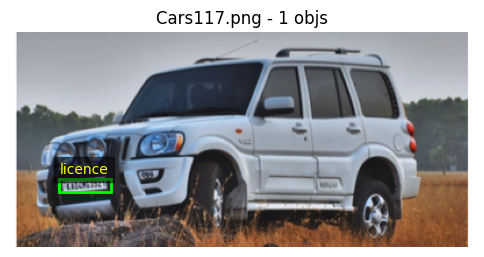

In [6]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sample_xml = random.choice(xmls)
t = ET.parse(sample_xml).getroot()
filename = t.findtext("filename")
img_path = img_dir / filename

size = t.find("size")
w = int(size.findtext("width"))
h = int(size.findtext("height"))

img = Image.open(img_path).convert("RGB")
fig, ax = plt.subplots(figsize=(6,4))
ax.imshow(img)

for obj in t.findall("object"):
    bb = obj.find("bndbox")
    xmin = int(bb.findtext("xmin"))
    ymin = int(bb.findtext("ymin"))
    xmax = int(bb.findtext("xmax"))
    ymax = int(bb.findtext("ymax"))
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, max(0,ymin-5), obj.findtext("name"), color='yellow', fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

ax.set_title(f"{filename} - {len(t.findall('object'))} objs")
ax.axis('off')
plt.show()

In [7]:
import shutil, yaml
from sklearn.model_selection import train_test_split

# Conversion function: VOC -> YOLO
class_map = {"licence": 0}

def voc_to_yolo(xmin, ymin, xmax, ymax, img_w, img_h):
    x_c = (xmin + xmax) / 2.0 / img_w
    y_c = (ymin + ymax) / 2.0 / img_h
    w = (xmax - xmin) / img_w
    h = (ymax - ymin) / img_h
    return x_c, y_c, w, h

# Prepare folders
out_root = Path("data/yolo")
img_out = out_root / "images"
lab_out = out_root / "labels"
for s in ["train","val"]:
    (img_out/s).mkdir(parents=True, exist_ok=True)
    (lab_out/s).mkdir(parents=True, exist_ok=True)

# Build list and split
all_items = []
for xp in xmls:
    t = ET.parse(xp).getroot()
    fname = t.findtext("filename")
    all_items.append((xp, img_dir / fname))

train_items, val_items = train_test_split(all_items, test_size=0.2, random_state=42, shuffle=True)

# Helper to write labels

def process_items(items, split):
    for xp, ip in items:
        t = ET.parse(xp).getroot()
        size = t.find("size")
        W = int(size.findtext("width")); H = int(size.findtext("height"))
        # copy image
        shutil.copy2(ip, img_out/split/ip.name)
        # write label
        lines = []
        for obj in t.findall("object"):
            name = obj.findtext("name")
            if name not in class_map:
                continue
            bb = obj.find("bndbox")
            xmin = int(bb.findtext("xmin")); ymin = int(bb.findtext("ymin"))
            xmax = int(bb.findtext("xmax")); ymax = int(bb.findtext("ymax"))
            x_c,y_c,w,h = voc_to_yolo(xmin,ymin,xmax,ymax,W,H)
            lines.append(f"{class_map[name]} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")
        with open(lab_out/split/(ip.stem + ".txt"), "w") as f:
            f.write("\n".join(lines))

process_items(train_items, Path("train"))
process_items(val_items, Path("val"))

# dataset YAML
names = [None]* (max(class_map.values())+1)
for k,v in class_map.items():
    names[v] = k

dataset_yaml = {
    'path': str(out_root.resolve()),
    'train': 'images/train',
    'val': 'images/val',
    'names': names
}

yaml_path = out_root / 'dataset.yaml'
with open(yaml_path, 'w') as f:
    yaml.safe_dump(dataset_yaml, f)

print("Created:", yaml_path)
print("Train images:", len(list((img_out/"train").glob("*.png"))))
print("Val images:", len(list((img_out/"val").glob("*.png"))))

Created: data/yolo/dataset.yaml
Train images: 346
Val images: 87


Sample: Cars375.png


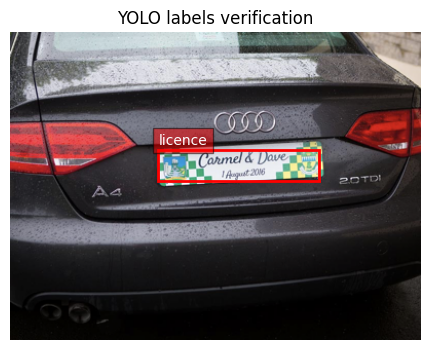

In [8]:
def yolo_to_xyxy(xc, yc, w, h, W, H):
    xmin = int((xc - w/2) * W)
    ymin = int((yc - h/2) * H)
    xmax = int((xc + w/2) * W)
    ymax = int((yc + h/2) * H)
    return xmin, ymin, xmax, ymax

sample_img = random.choice(list((img_out/"train").glob("*.png")))
label_file = lab_out/"train"/(sample_img.stem + ".txt")
print("Sample:", sample_img.name)

img = Image.open(sample_img).convert("RGB")
W, H = img.size
fig, ax = plt.subplots(figsize=(6,4))
ax.imshow(img)

if label_file.exists():
    with open(label_file) as f:
        for line in f:
            cls, xc, yc, w, h = line.strip().split()
            xc, yc, w, h = map(float, (xc, yc, w, h))
            xmin, ymin, xmax, ymax = yolo_to_xyxy(xc, yc, w, h, W, H)
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, max(0,ymin-5), names[int(cls)], color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))
else:
    print("No labels found for", sample_img)

ax.set_title("YOLO labels verification")
ax.axis('off')
plt.show()

train: 346 images, 346 label files
  Objects: 377, Invalid label lines: 0
val: 87 images, 87 label files
  Objects: 94, Invalid label lines: 0
VERIFIED: Label integrity check complete.


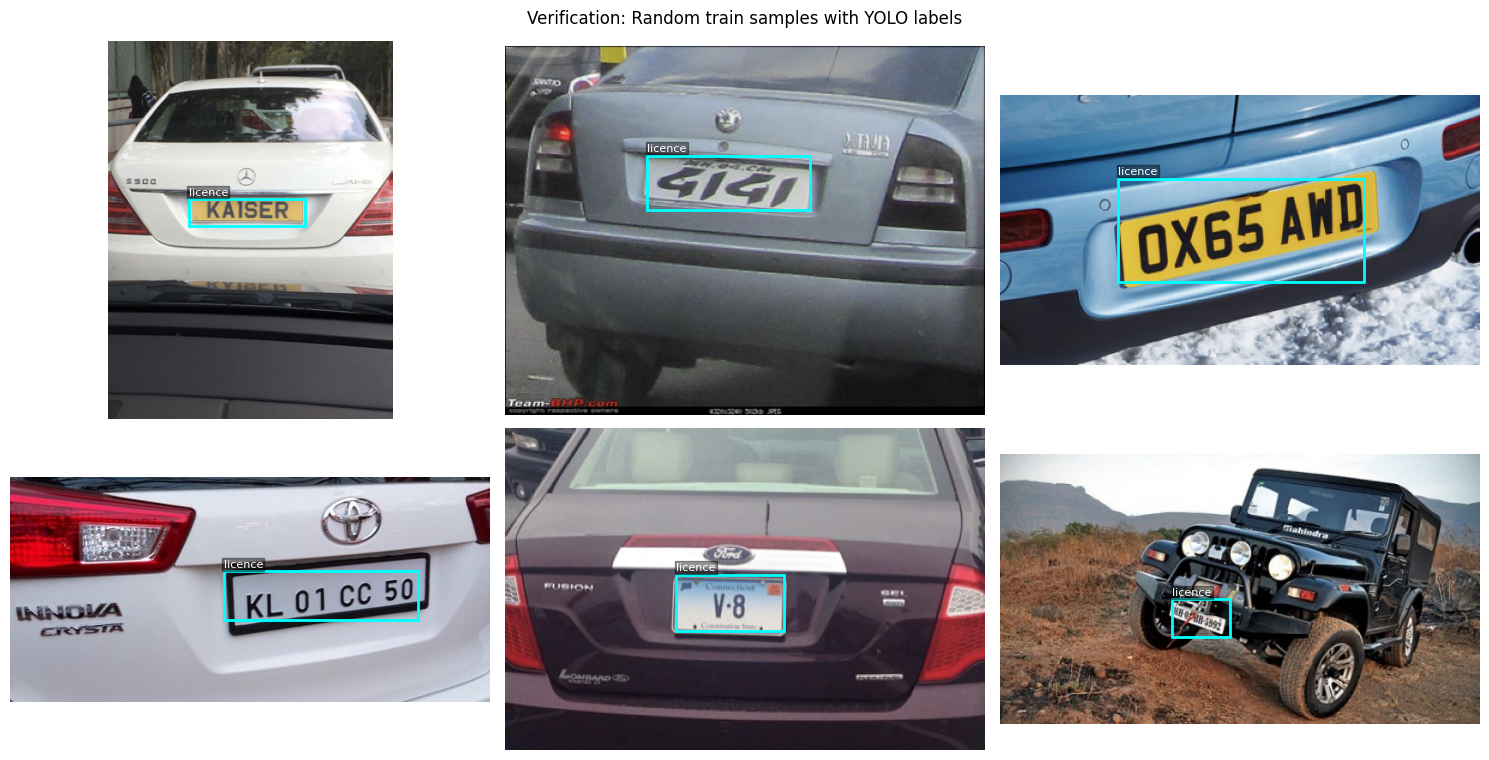

VERIFIED: Visual sample grid displayed.


In [9]:
# Verification: label integrity + visual grid (run after conversion cells)
from pathlib import Path
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Expect img_out, lab_out, and names to be defined by previous conversion cells

def check_split(split: Path):
    img_paths = list((img_out / split).glob('*.png'))
    lbl_paths = list((lab_out / split).glob('*.txt'))
    print(f"{split}: {len(img_paths)} images, {len(lbl_paths)} label files")

    missing_lbl = [p.name for p in img_paths if not (lab_out / split / (p.stem + '.txt')).exists()]
    extra_lbl = [p.name for p in lbl_paths if not (img_out / split / (p.stem + '.png')).exists()]
    if missing_lbl:
        print('  Missing labels for images (first 5):', missing_lbl[:5])
    if extra_lbl:
        print('  Extra labels without matching image (first 5):', extra_lbl[:5])

    invalid = 0
    obj_count = 0
    for lf in lbl_paths:
        text = lf.read_text().strip()
        if not text:
            continue
        for line in text.splitlines():
            parts = line.strip().split()
            if len(parts) != 5:
                invalid += 1
                continue
            cls, xc, yc, w, h = parts
            try:
                cls = int(float(cls))
                xc, yc, w, h = map(float, (xc, yc, w, h))
            except ValueError:
                invalid += 1
                continue
            if not (0 <= xc <= 1 and 0 <= yc <= 1 and 0 < w <= 1 and 0 < h <= 1):
                invalid += 1
            obj_count += 1
    print(f"  Objects: {obj_count}, Invalid label lines: {invalid}")
    return {'images': len(img_paths), 'labels': len(lbl_paths), 'objects': obj_count, 'invalid': invalid}

stats_train = check_split(Path('train'))
stats_val = check_split(Path('val'))
print('VERIFIED: Label integrity check complete.')

# Visual grid on random training samples with their YOLO labels
train_imgs = list((img_out / 'train').glob('*.png'))
if train_imgs:
    k = min(6, len(train_imgs))
    samples = random.sample(train_imgs, k=k)
    cols = min(3, k)
    rows = (k + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten() if k > 1 else [axes]

    for ax, imgp in zip(axes, samples):
        img = Image.open(imgp).convert('RGB')
        W, H = img.size
        ax.imshow(img)
        lblp = lab_out / 'train' / (imgp.stem + '.txt')
        if lblp.exists():
            for line in lblp.read_text().strip().splitlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, xc, yc, w, h = parts
                xc, yc, w, h = map(float, (xc, yc, w, h))
                xmin = int((xc - w/2) * W)
                ymin = int((yc - h/2) * H)
                xmax = int((xc + w/2) * W)
                ymax = int((yc + h/2) * H)
                ax.add_patch(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, edgecolor='cyan', linewidth=2))
                try:
                    cls_name = names[int(float(cls))]
                except Exception:
                    cls_name = str(cls)
                ax.text(xmin, max(0, ymin-4), cls_name, color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.4, pad=1))
        ax.axis('off')
    for ax in axes[k:]:
        ax.axis('off')
    plt.suptitle('Verification: Random train samples with YOLO labels', y=0.98)
    plt.tight_layout()
    plt.show()
    print('VERIFIED: Visual sample grid displayed.')
else:
    print('No training images found for visualization.')

In [ ]:
import sys, subprocess, importlib

def ensure_ultralytics():
    try:
        return importlib.import_module('ultralytics')
    except ImportError:
        print('Installing ultralytics...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'ultralytics==8.*'])
        return importlib.import_module('ultralytics')

ultralytics = ensure_ultralytics()
from ultralytics import YOLO

# Use a small pretrained model and quick run for verification
model = YOLO('yolov8n.pt')
results = model.train(data=str(yaml_path), epochs=5, imgsz=640, batch=16, workers=2, name='plates_yolov8n_sanity', project='runs', verbose=True)

print('Training done. Last metrics dir:', results.save_dir)

Ultralytics 8.3.176 🚀 Python-3.10.18 torch-2.8.0+cpu CPU (Intel Core(TM) i5-8350U 1.70GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/yolo/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=plates_yolov8n_sanity2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose

train: Scanning /home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /data/yolo/labels/train.cache... 346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1617.2±698.0 MB/s, size: 472.7 KB)



/home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolovenv/lib64/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /data/yolo/labels/val.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]
/home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolovenv/lib64/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)

/home/naki/Desktop/Y'all aint seen shit/YOLO Vehicle number plate /yolovenv/lib64/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then devic

Plotting labels to runs/plates_yolov8n_sanity2/labels.jpg... 
WARNING ⚠️ 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/plates_yolov8n_sanity2
Starting training for 5 epochs...
WARNING ⚠️ 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/plates_yolov8n_sanity2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        1/5         0G      1.662      3.928      1.459         27        640:  23%|██▎       | 5/22 [02:34<08:01, 28.30s/it]

In [ ]:
# Load best weights and predict on a few images
best_weights = Path('runs') / 'detect' / 'plates_yolov8n_sanity' / 'weights' / 'best.pt'
if not best_weights.exists():
    # fallback to last
    best_weights = Path('runs') / 'detect' / 'plates_yolov8n_sanity' / 'weights' / 'last.pt'

print('Using weights:', best_weights)

model = YOLO(str(best_weights))
vis_dir = Path('tmp/preds')
vis_dir.mkdir(parents=True, exist_ok=True)

subset = list((img_out/"val").glob("*.png"))[:8]
for imgp in subset:
    pred = model.predict(source=str(imgp), conf=0.25, save=True, project=str(vis_dir), name='yolo_preds', exist_ok=True, imgsz=640)

print('Saved predictions to', vis_dir / 'yolo_preds')

Using weights: runs/detect/plates_yolov8n_sanity/weights/last.pt


FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/plates_yolov8n_sanity/weights/last.pt'

In [13]:
# Recovery / auto-discovery of trained weights
from pathlib import Path
from datetime import datetime
try:
    from ultralytics import YOLO
except Exception as e:
    print('Ultralytics not imported, install first. Skipping.')
else:
    search_roots = [Path('runs'), Path('runs_yolo')]
    found = []
    for root in search_roots:
        if root.exists():
            found.extend(root.rglob('last.pt'))
            found.extend(root.rglob('best.pt'))
    if not found:
        print('No weight files found under runs/ or runs_yolo/. Train a model first.')
    else:
        # Prefer best.pt over last.pt, newest mtime
        def sort_key(p):
            score = 0 if p.name == 'best.pt' else 1  # best preferred
            return (score, -p.stat().st_mtime)
        found_sorted = sorted(found, key=sort_key)
        chosen = found_sorted[0]
        print('Discovered weight candidates:')
        for p in found_sorted[:10]:
            print(' -', p, datetime.fromtimestamp(p.stat().st_mtime))
        print('\nUsing weights:', chosen)
        try:
            model = YOLO(str(chosen))
            print('VERIFIED: Model loaded successfully.')
        except Exception as e:
            print('Failed to load chosen weights:', e)
            print('Re-run training cell or adjust path manually.')

Discovered weight candidates:
 - runs_yolo/plate_det_v8n/weights/best.pt 2025-08-09 16:49:14.116336
 - runs_yolo/plate_det_v8n/weights/last.pt 2025-08-09 16:49:13.875336

Using weights: runs_yolo/plate_det_v8n/weights/best.pt
VERIFIED: Model loaded successfully.


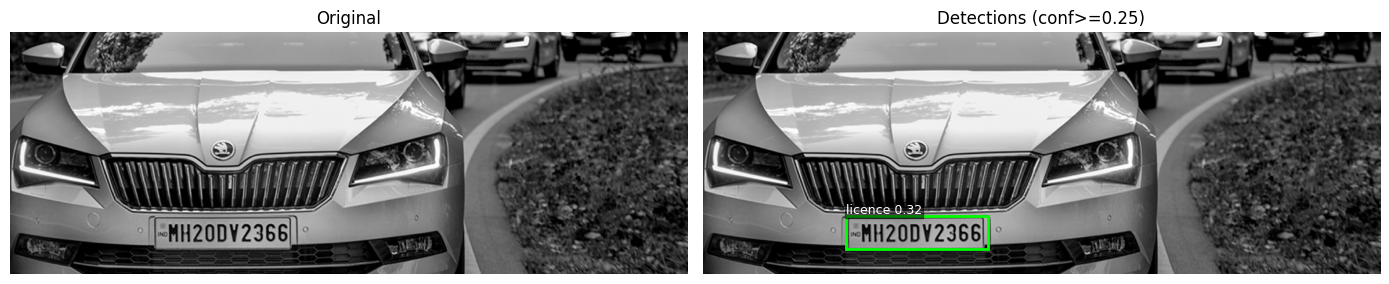

VERIFIED: Inference complete. Annotated image saved to tmp/single_infer/Skoda-Superb-BW-India_annotated.png


In [15]:
# Custom single-image inference (set image_path below)
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# --- User configuration ---
image_path = Path('try/Skoda-Superb-BW-India.jpg')  # <-- change to your image path
weights_path = None  # Optionally set a specific weights .pt file path; leave None to auto-discover
conf_threshold = 0.25
# ---------------------------

try:
    from ultralytics import YOLO
except ImportError as e:
    raise RuntimeError('Ultralytics not installed. Run the training/install cells first.') from e

# Load model if not already in memory
if 'model' not in globals() or model is None:
    if weights_path is None:
        search_roots = [Path('runs'), Path('runs_yolo')]
        candidates = []
        for root in search_roots:
            if root.exists():
                candidates.extend(root.rglob('best.pt'))
                candidates.extend(root.rglob('last.pt'))
        if not candidates:
            raise FileNotFoundError('No weights found. Train a model or set weights_path.')
        def sort_key(p):
            return (0 if p.name == 'best.pt' else 1, -p.stat().st_mtime)
        chosen = sorted(candidates, key=sort_key)[0]
    else:
        chosen = Path(weights_path)
        if not chosen.exists():
            raise FileNotFoundError(f'Specified weights_path not found: {chosen}')
    model = YOLO(str(chosen))
    print('Loaded model from', chosen)
else:
    if weights_path:
        # Optionally reload with provided weights
        wp = Path(weights_path)
        if not wp.exists():
            raise FileNotFoundError(f'Specified weights_path not found: {wp}')
        model = YOLO(str(wp))
        print('Reloaded model from', wp)

if not image_path.exists():
    raise FileNotFoundError(f'Image not found: {image_path}. Set image_path to a valid file.')

# Run prediction
results = model.predict(source=str(image_path), conf=conf_threshold, verbose=False)
res = results[0]

orig = Image.open(image_path).convert('RGB')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(orig)
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(orig)
axes[1].set_title('Detections (conf>=' + str(conf_threshold) + ')')
axes[1].axis('off')

boxes = getattr(res, 'boxes', None)
if boxes is not None and boxes.xyxy.numel() > 0:
    for (x1, y1, x2, y2), conf, cls in zip(boxes.xyxy.tolist(), boxes.conf.tolist(), boxes.cls.tolist()):
        axes[1].add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                            fill=False, edgecolor='lime', linewidth=2))
        label = f'licence {conf:.2f}'
        axes[1].text(x1, max(0, y1 - 5), label, color='white', fontsize=9,
                     bbox=dict(facecolor='black', alpha=0.5, pad=1))
else:
    axes[1].text(0.5, 0.5, 'No detections', ha='center', va='center', color='red', fontsize=16,
                 bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()

# Optional: save annotated figure
out_dir = Path('tmp/single_infer')
out_dir.mkdir(parents=True, exist_ok=True)
annot_path = out_dir / f'{image_path.stem}_annotated.png'
fig.savefig(annot_path)
print('VERIFIED: Inference complete. Annotated image saved to', annot_path)